In [1]:
# !conda install tqdm -y

In [2]:
# !pip install seaborn

In [3]:
import os
import ast
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# !pip install sktime

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sktime.transformations.panel.rocket import MiniRocketMultivariate

In [6]:
from tsai.all import *

In [7]:
my_setup()

os              : Linux-5.14.0-503.11.1.el9_5.x86_64-x86_64-with-glibc2.34
python          : 3.12.8
tsai            : 0.4.1
fastai          : 2.8.2
fastcore        : 1.8.2
torch           : 2.5.1+cu124
device          : 1 gpu (['NVIDIA GeForce RTX 2080 Ti'])
cpu cores       : 16
threads per cpu : 2
RAM             : 93.54 GB
GPU memory      : [11.0, 11.0, 11.0, 11.0] GB


In [8]:
def extend_df(
        df: pd.DataFrame, 
        target_size: int
    ) -> pd.DataFrame:

    current_size = len(df)
    last_row = df.iloc[[-1]]
    repeats = target_size - current_size
    extension = pd.concat([last_row] * repeats, ignore_index=True)
    extension.index = range(current_size, target_size)
    
    return pd.concat([df, extension])

In [9]:
df_meta = pd.read_csv('../../sensor_fusion/df_meta_withJSON_withTimes_goodDetections_min2700.csv', index_col=0)

In [10]:
df_meta.head()

,study_id,premature,gestational_age_weeks,post_menstrual_age_days,adjusted_age_weeks,chronological_age_weeks,over3m,sex,diagnosis,y_true,...,dirname_json,start_time1,stop_time1,start_time2,stop_time2,num_frames_mkv,num_frames_json,num_frames_diff,num_scaled_snippets,fnames_scaled_snippets
0,592,0,38,294.0,40,4,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/592-aafcb787-M-28-2010221627,2700,5400,-1,-1,7196,7197,1,2,"['592-aafcb787-M-28-2010221627_df_scaled_snippet_idx0.csv', '592-aafcb787-M-28-2010221627_df_scaled_snippet_idx1.csv']"
1,1838,0,40,330.0,47,7,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/1838-1976fc8e-M-44-2010271018,3450,6150,-1,-1,7202,7203,1,2,"['1838-1976fc8e-M-44-2010271018_df_scaled_snippet_idx0.csv', '1838-1976fc8e-M-44-2010271018_df_scaled_snippet_idx1.csv']"
2,8015,0,39,314.0,43,5,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/8015-d6a22f17-M-39-2010291126,1500,4200,-1,-1,7196,7197,1,2,"['8015-d6a22f17-M-39-2010291126_df_scaled_snippet_idx0.csv', '8015-d6a22f17-M-39-2010291126_df_scaled_snippet_idx1.csv']"
3,8026,0,40,488.0,69,29,1,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/8026-0e213ab6-M-207-2010301654,960,3660,-1,-1,7196,7197,1,2,"['8026-0e213ab6-M-207-2010301654_df_scaled_snippet_idx0.csv', '8026-0e213ab6-M-207-2010301654_df_scaled_snippet_idx1.csv']"
4,24034,0,37,339.0,45,11,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/24034-15d9bab8-M-76-2011051205_M,3690,6390,-1,-1,7196,7197,1,2,"['24034-15d9bab8-M-76-2011051205_M_df_scaled_snippet_idx0.csv', '24034-15d9bab8-M-76-2011051205_M_df_scaled_snippet_idx1.csv']"


In [11]:
# df_meta.shape

In [14]:
df_meta_Normal = df_meta[df_meta['diagnosis']=='Normal']
df_meta_CP     = df_meta[df_meta['diagnosis']=='CP']

In [15]:
df_meta_Normal.shape, df_meta_CP.shape

((551, 28), (37, 28))

In [75]:
df_meta_CP_train, df_meta_CP_test = train_test_split(
    df_meta_CP, test_size=0.25
)

In [76]:
num_snippets_CP_train = int(df_meta_CP_train['num_scaled_snippets'].sum())

In [77]:
num_snippets_CP_test  = int(df_meta_CP_test['num_scaled_snippets'].sum())

In [78]:
num_snippets_CP_train, num_snippets_CP_test

(65, 22)

In [79]:
dfs_combined_CP_train = []

for i in tqdm( range( len(df_meta_CP_train) ) ):

    row = df_meta_CP_train.iloc[i]
    
    dirname_json = row['dirname_json']

    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for j, fname in enumerate(fnames_scaled_snippets_full[:]):

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            
            dfs_combined_CP_train.append( dfs_combined )
            
        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            
            dfs_combined_CP_train.append( dfs_combined_extended )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:08<00:00,  3.35it/s]


In [80]:
len(dfs_combined_CP_train)

65

In [139]:
df_meta_CP[ df_meta_CP['over3m']==0 ]['num_scaled_snippets'].sum()

np.int64(55)

In [140]:
df_meta_CP[ df_meta_CP['over3m']==1 ]['num_scaled_snippets'].sum()

np.int64(32)

In [81]:
# Subject Disjoint Cross-Validation Sets

In [82]:
dfs_combined_CP_test = []

for i in tqdm( range( len(df_meta_CP_test) ) ):

    row = df_meta_CP_test.iloc[i]
    
    dirname_json = row['dirname_json']

    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for j, fname in enumerate(fnames_scaled_snippets_full[:]):

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            
            dfs_combined_CP_test.append( dfs_combined )
            
        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            
            dfs_combined_CP_test.append( dfs_combined_extended )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.51it/s]


In [83]:
len(dfs_combined_CP_test)

22

In [84]:
dfs_combined_Normal = []

for _, row in df_meta_Normal.sample( 
        num_snippets_CP_train + num_snippets_CP_test,
    ).iterrows():

    dirname_json = row['dirname_json']
    
    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for fname in fnames_scaled_snippets_full[:1]:

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            dfs_combined_Normal.append( dfs_combined )

        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            dfs_combined_Normal.append( dfs_combined_extended )

In [85]:
dfs_combined_Normal_train = dfs_combined_Normal[:len(dfs_combined_CP_train)]

In [86]:
dfs_combined_Normal_test = dfs_combined_Normal[len(dfs_combined_CP_train):]

In [89]:
# len(dfs_combined_Normal_train), len(dfs_combined_Normal_test)

In [90]:
dfs_combined_train = dfs_combined_CP_train + dfs_combined_Normal_train

In [91]:
dfs_combined_test  = dfs_combined_CP_test + dfs_combined_Normal_test

In [92]:
len(dfs_combined_train), len(dfs_combined_test)

(130, 44)

In [93]:
X_train = []
for dfs_combined in dfs_combined_train:
    X_train.append( dfs_combined.values )

In [94]:
y_train = [1] * len(dfs_combined_CP_train) + [0] * len(dfs_combined_Normal_train)

In [95]:
y_train_arr = np.asarray(y_train)

In [96]:
X_test = []
for dfs_combined in dfs_combined_test:
    X_test.append( dfs_combined.values )

In [97]:
y_test = [1] * len(dfs_combined_CP_test) + [0] * len(dfs_combined_Normal_test)

In [98]:
y_test_arr = np.asarray(y_test)

In [99]:
# len(y_train_arr), len(y_test_arr)

In [100]:
X_train_arr = np.asarray(X_train).transpose( (0,2,1 ) )

In [101]:
X_test_arr  = np.asarray(X_test).transpose( (0,2,1 ) )

In [102]:
# X_train_arr.shape, X_test_arr.shape

In [132]:
lms_using4 = [
    'left_wrist','right_wrist','left_ankle','right_ankle'
]

In [133]:
lms_using8 = [
    'left_wrist','right_wrist','left_ankle','right_ankle',
    'left_shoulder','right_shoulder','left_hip','right_hip'
]

In [103]:
# Decide which columns/features to use

In [104]:
feature_sets = set( [col.split('__')[0] for col in dfs_combined.columns] )

In [105]:
feature_sets

{'lm2dists_centroid_2d',
 'lm2dists_centroid_3d',
 'lm2dists_framewise_2d',
 'lm2dists_framewise_3d',
 'lm_pair2dists_2d',
 'lm_pair2dists_3d',
 'lm_triple2angles',
 'polar_coords',
 'pos_2d',
 'pos_3d'}

In [106]:
feature_set2col_indices = {
    feature_set: [i for i, col in enumerate(dfs_combined.columns) if feature_set in col ] for feature_set in feature_sets
}

In [107]:
# feature_set2col_indices

In [108]:
# col_indices = []
# for feature_set in ['lm2dists_framewise_2d']:

In [109]:
col_indices = []
for feature_set in ['pos_3d']:
    col_indices_tmp = feature_set2col_indices[feature_set]
    for col_idx in col_indices_tmp:
        col_indices.append(col_idx)

In [110]:
len( col_indices )

36

In [111]:
skip = 5

In [112]:
X_train_arr_smaller = X_train_arr[:,col_indices,::skip]
# X_train_arr_smaller = X_train_arr[:,:,::skip]
# X_train_arr_smaller = X_train_arr[:,col_indices,:]
# X_train_arr_smaller = X_train_arr[:,:,:]

In [113]:
X_test_arr_smaller = X_test_arr[:,col_indices,::skip]
# X_test_arr_smaller = X_test_arr[:,:,::skip]
# X_test_arr_smaller = X_test_arr[:,col_indices,:]
# X_test_arr_smaller = X_test_arr[:,:,:]

In [114]:
X_train_arr_smaller.shape, X_test_arr_smaller.shape

((130, 36, 540), (44, 36, 540))

In [115]:
X_tsai, y_tsai, splits = combine_split_data(
    [X_train_arr_smaller, X_test_arr_smaller], [y_train_arr, y_test_arr]
)

In [116]:
len(X_tsai)

174

In [117]:
bs = 16
n_epochs = 100

In [118]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize()]

In [119]:
dsets = TSDatasets(X_tsai, y_tsai, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=batch_tfms)

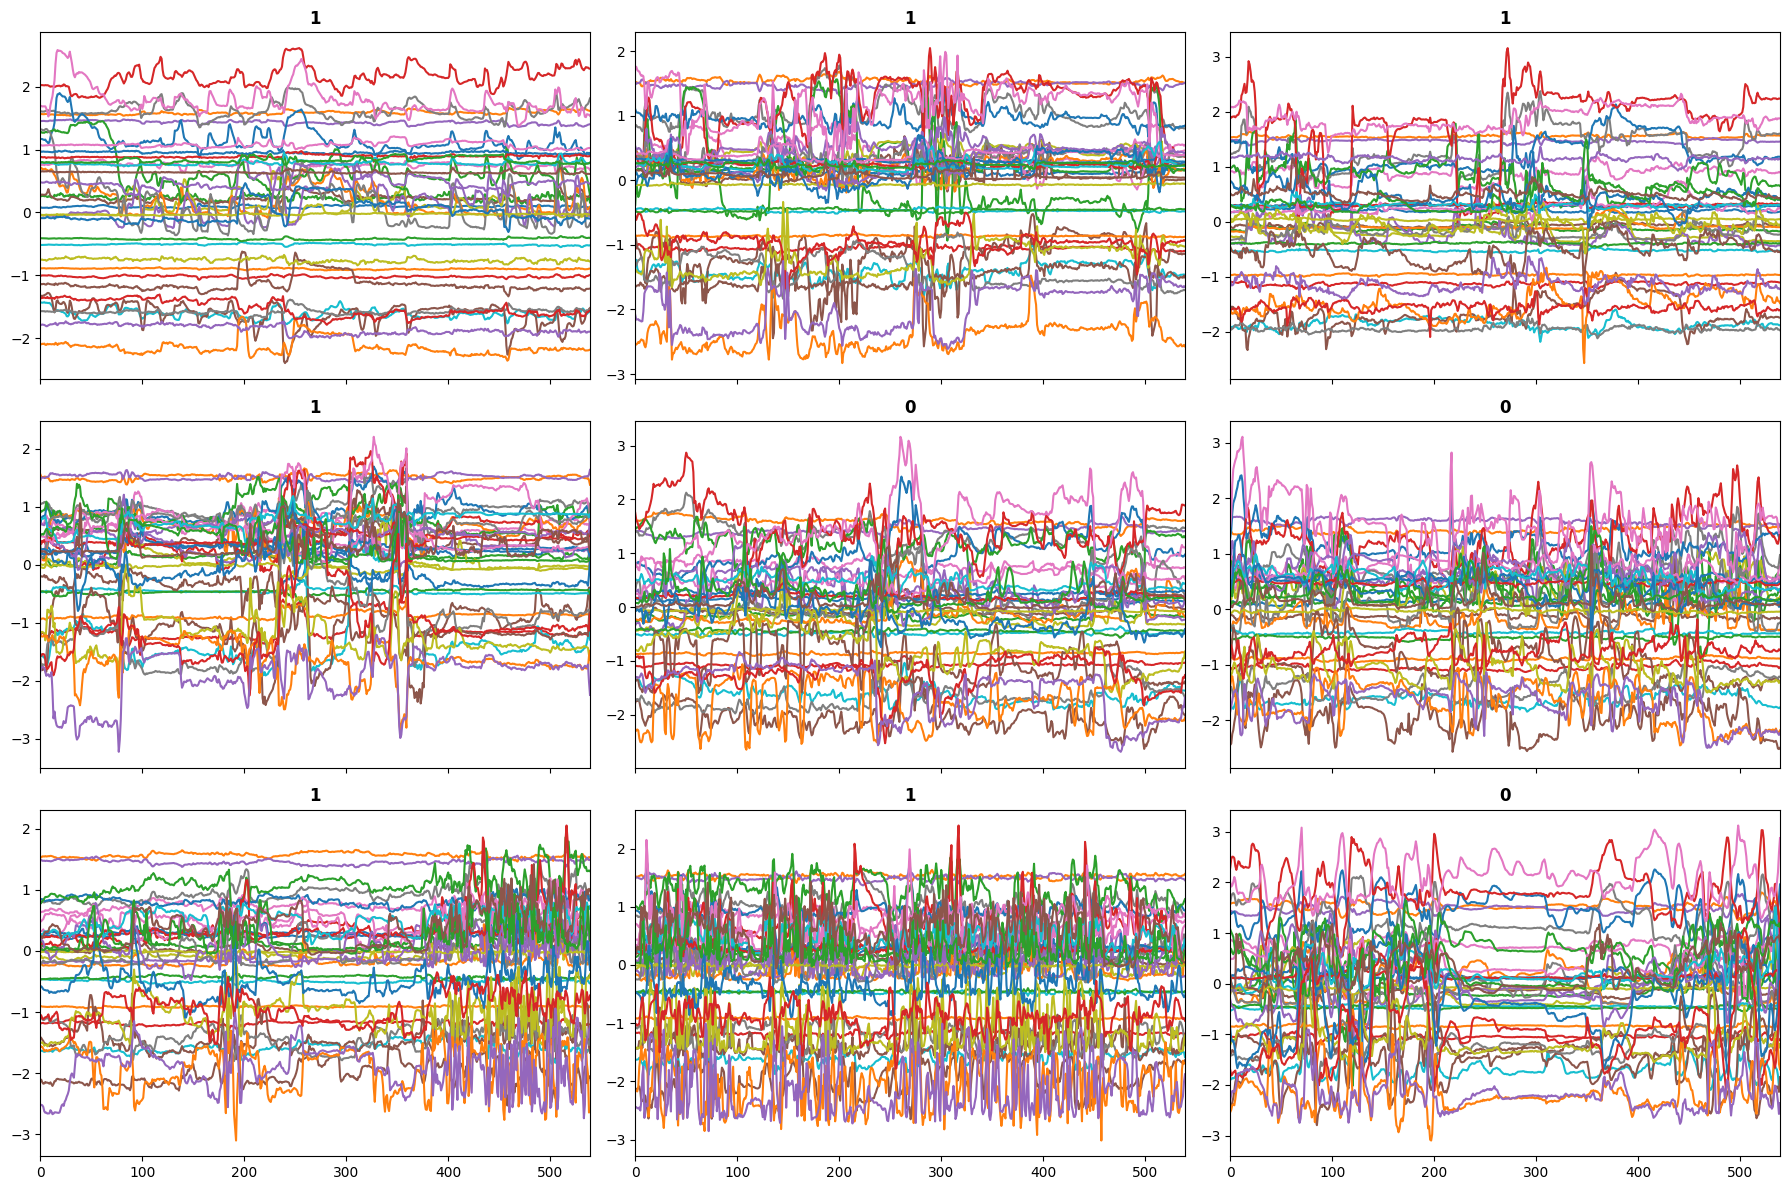

In [120]:
dls.show_batch()

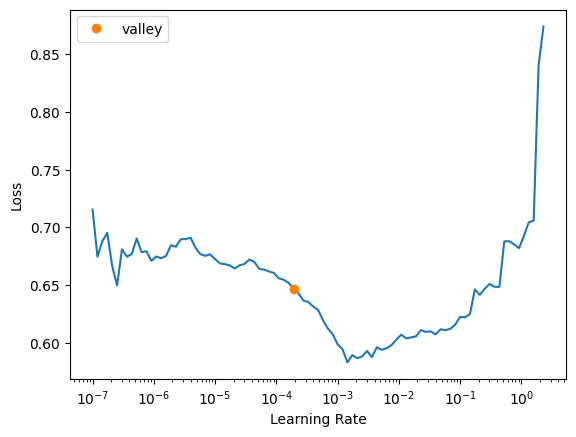

In [121]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, 
                metrics=[RocAucBinary(), accuracy, Precision(), F1Score()], 
                cbs=ShowGraphCallback2())
lr_max = learn.lr_find()[0]

In [122]:
lr_max

0.00019054606673307717

epoch,train_loss,valid_loss,roc_auc_score,accuracy,precision_score,f1_score,time
0,0.681484,0.709596,0.353306,0.431818,0.459459,0.576271,00:00
1,0.665885,0.704741,0.411157,0.409091,0.423077,0.458333,00:00
2,0.660320,0.710277,0.398760,0.363636,0.333333,0.300000,00:00
3,0.651166,0.725174,0.373967,0.409091,0.375000,0.315789,00:00
4,0.639093,0.736389,0.386364,0.431818,0.400000,0.324324,00:00
5,0.625617,0.737843,0.452479,0.454545,0.437500,0.368421,00:00
6,0.611030,0.740571,0.481405,0.477273,0.470588,0.410256,00:00
7,0.590590,0.749231,0.526860,0.454545,0.437500,0.368421,00:00
8,0.571571,0.798844,0.516529,0.477273,0.466667,0.378378,00:00
9,0.544230,0.807931,0.530992,0.454545,0.437500,0.368421,00:00


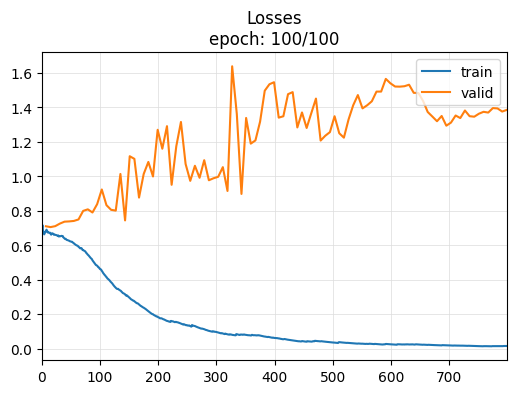

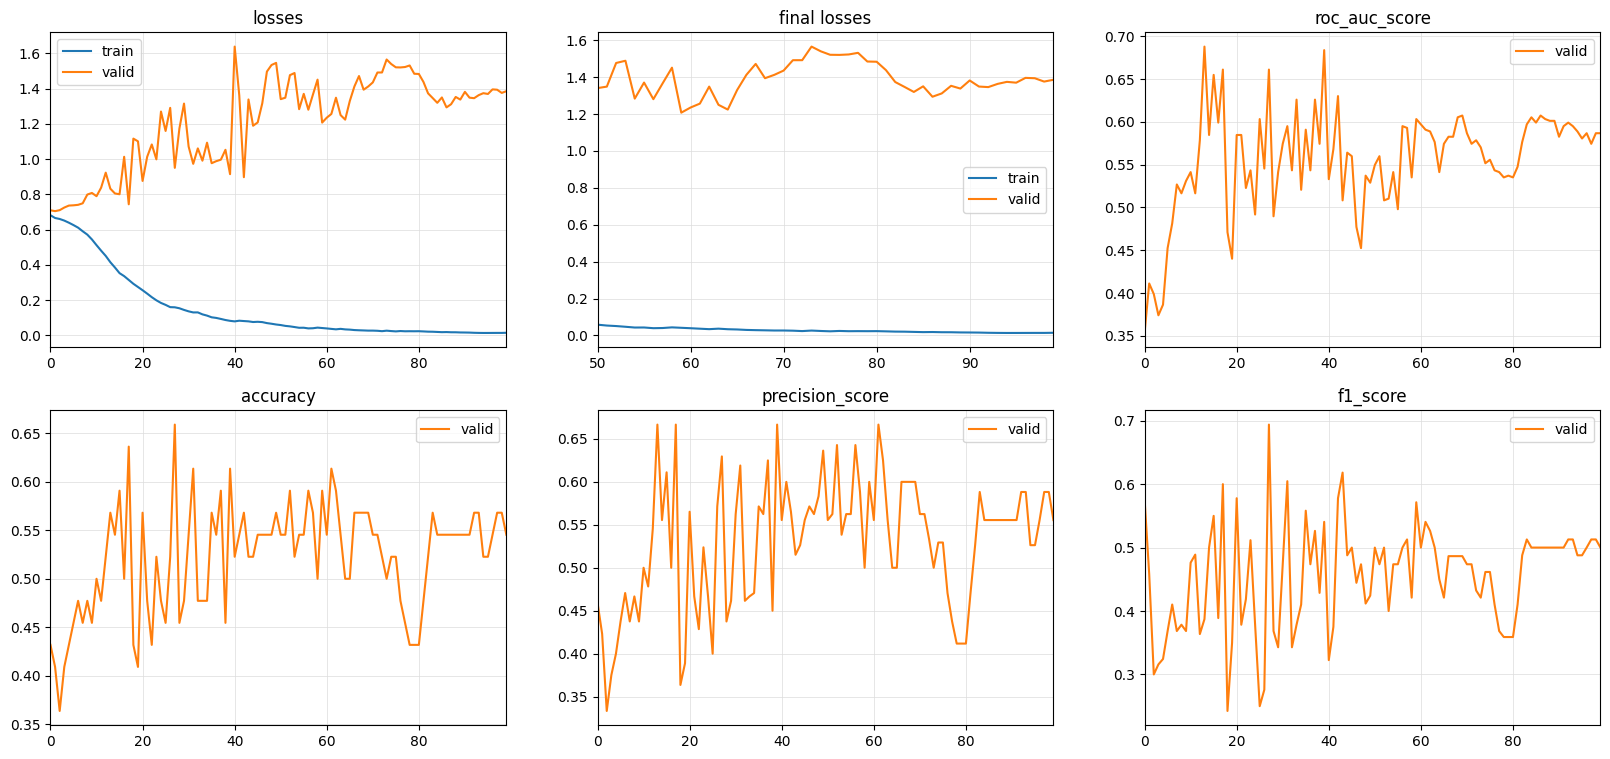


Elapsed time: 32.66674518585205


In [123]:
start = time.time()
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
print('\nElapsed time:', time.time() - start)